In [1]:
import sys
import socket
import pandas as pd
import random
import os
import json
import numpy as np
from pyspark.rdd import RDD
from pyspark.sql import SparkSession,Row
from pyspark import TaskContext
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from time import *
from datetime import datetime
from sklearn.linear_model import SGDClassifier
from multiprocessing.pool import ThreadPool
#___________________________________________________________________________________________________________
memory = 64
overhead = int(memory*1024*0.07)
ememory = (memory * 1024 - overhead)/1024 + 1
overhead

4587

In [2]:
spark = SparkSession.builder.appName(
    "fpg-RunLogoV_Spark"
).config(
    "spark.executor.memory","4g"
).config(
    "spark.executor.cores","4"
).config(
    "spark.kryoserializer.buffer.max", "1024m"
).config(
    "yarn.nodemanager.vmem-check-enabled","false"
).config(
    "yarn.nodemanager.pmem-check-enabled","false"
).config(
    "spark.executor.instances","10"
).getOrCreate()
#___________________________________________________________________________________________________________
logov = "/user/luokaijing/fpg/logov/size_10"
sparkmllib = "/user/luokaijing/fpg/sparkFPG_shiyan/size_10blocks_parquet"
#___________________________________________________________________________________________________________
logo1 = "/user/luokaijing/FimExperiments/FimOutput-2023-04-12T17-03-58-/user/luokaijing/tianhong1/20200731_Version3_Final_100Blocks_26W_1.parquet-0.010000_10Block_ScaDist.parquet"
spark2 = "/user/luokaijing/tianhong1/20200731_Version3_Final_100Blocks_26W_1.parquet"
spark1 = "/user/luokaijing/FimExperiments/FimOutput-2023-04-12T17-10-03-/user/luokaijing/tianhong1/20200731_Version3_Final_100Blocks_26W_1.parquet-0.010000_10Block_Spark.parquet"

In [97]:
rawDF1 = spark.read.parquet(logov)
rawDF1.show()
rawDF1.count()

+-------------------+-------+
|              items|support|
+-------------------+-------+
|        {3303,9908}|   7399|
|{501,907,6315,9908}|   5635|
|          {907,922}|   6457|
|        {2634,9609}|   2704|
|    {501,6305,6315}|   4808|
|        {4107,5620}|   3141|
|    {907,5705,9908}|   2944|
|        {5824,9753}|   3717|
|    {907,3601,6320}|   3006|
|    {907,6315,6316}|   2947|
|    {901,9908,9909}|   3008|
|{902,907,3303,6315}|   2976|
|   {3611,6315,6320}|   3498|
|        {5115,6315}|   4467|
|         {902,2105}|   3160|
|    {907,3618,6320}|   2756|
|        {2609,9753}|   3223|
|         {501,2106}|   2891|
|         {907,5613}|   3204|
|        {3801,6320}|   3035|
+-------------------+-------+
only showing top 20 rows



1769

In [37]:
rawDF2 = spark.read.parquet(sparkmllib)
rawDF2.show()
rawDF2.count()

+-------------------+-------+
|              items|support|
+-------------------+-------+
|        {3303,9908}|   7399|
|{501,907,6315,9908}|   5635|
|          {907,922}|   6457|
|        {2634,9609}|   2704|
|    {501,6305,6315}|   4808|
|        {4107,5620}|   3141|
|    {907,5705,9908}|   2944|
|        {5824,9753}|   3717|
|    {907,3601,6320}|   3006|
|    {907,6315,6316}|   2947|
|    {901,9908,9909}|   3008|
|{902,907,3303,6315}|   2976|
|   {3611,6315,6320}|   3498|
|        {5115,6315}|   4467|
|         {902,2105}|   3160|
|    {907,3618,6320}|   2756|
|        {2609,9753}|   3223|
|         {501,2106}|   2891|
|         {907,5613}|   3204|
|        {3801,6320}|   3035|
+-------------------+-------+
only showing top 20 rows



In [98]:
rawDF1[rawDF1["items"]=='{901,9908,9909}'].show()
rawDF2[rawDF2["items"]=='{901,9908,9909}'].show()

+---------------+-------+
|          items|support|
+---------------+-------+
|{901,9908,9909}|   3008|
+---------------+-------+

+---------------+-------+
|          items|support|
+---------------+-------+
|{901,9908,9909}|  30086|
+---------------+-------+



In [100]:
ox = rawDF1.select("items").rdd.map(lambda r : r[0][1:-1].split(",")).collect()
oxx = [[int(numeric_string1) for numeric_string1 in numeric_string] for numeric_string in ox]

oy = rawDF2.select("items").rdd.map(lambda r : r[0][1:-1].split(",")).collect()
oyy = [sorted([int(numeric_string1) for numeric_string1 in numeric_string]) for numeric_string in oy]

In [102]:
len(oxx) #logoV

1769

In [103]:
len(oyy) #Spark

1757

In [94]:
trueZhenZhi1 = 0
for a in ox:
    for b in oy:
        if len(a)==len(b):
            s = set(a)
            ss = set(b)
            tmp = len(s.intersection(ss))
            if tmp==len(s):
                trueZhenZhi1 = trueZhenZhi1 + 1
trueZhenZhi1

1752

In [95]:
1752/len(oxx) #准确率

0.9903900508762012

In [96]:
1752/len(oyy) #召回率

0.9971542401821286

In [60]:
# 字符串格式的：
trueZhenZhi = 0
for a in ox:
    for b in oy:
        if a==b: 
            print(a)
            trueZhenZhi = trueZhenZhi + 1
trueZhenZhi

{3303,9908}
{907,922}
{2634,9609}
{501,6305,6315}
{4107,5620}
{5824,9753}
{901,9908,9909}
{3611,6315,6320}
{5115,6315}
{2609,9753}
{3801,6320}
{6305,6315,9904}
{907,9753,9908,9909}
{9908,9909}
{2633,6315}
{3618,6315}
{2628,6320}
{0,5824}
{501,5823,6315}
{501,502}
{5824,9609}
{2628,3611}
{5401,6315}
{6320,9753}
{2914,6320}
{5902,6315,9904}
{3305,9753}
{3315,6315}
{501,9908,9909}
{5710,6315,9909}
{818,901}
{3303,5902}
{3001,6315}
{5902,9909}
{3305,9609}
{0,9753,9909}
{5607,6320}
{5552,6305}
{2628,6315,9753}
{201,907}
{902,9904,9908}
{2622,6315}
{902,9753}
{908,9753}
{2506,9609}
{502,907}
{922,9753}
{907,913}
{5827,6315,9908}
{0,902,9908}
{0,6315,9753}
{0,6315,9609}
{0,2628,6315}
{3101,9904}
{5705,6315,6320}
{5823,6315,9904}
{5617,9908}
{803,907}
{5710,6305}
{2506,9753}
{501,908}
{5704,6315}
{3611,9908}
{501,902,907,9753}
{3703,9908}
{2301,5620}
{907,917,9908}
{5552,9753}
{3303,6315,6320}
{501,6320,9609}
{5812,6315}
{4107,6315,9904}
{6320,9609}
{3601,6315}
{2628,2630}
{5710,9609}
{3612,63

1031

In [172]:
fx = rawDF1.select("frequency").rdd.map(lambda r : r[0]).collect()

In [173]:
fy = rawDF2.select("frequency").rdd.map(lambda r : r[0]).collect()

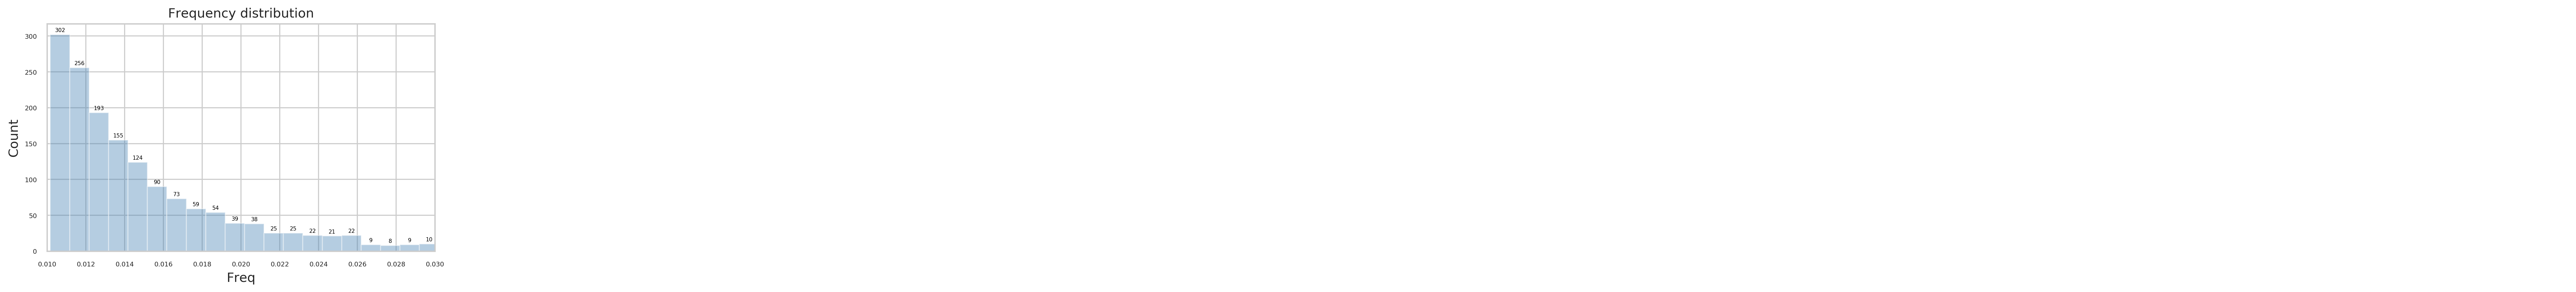

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import MultipleLocator

rc = {'font.sans-serif': 'SimSun',
      'axes.unicode_minus': True,
     'figure.dpi':300}
sns.set(rc=rc,style="whitegrid")  #切换到sns的默认运行配置

def draw_distribution_histogram(nums, path, is_hist=True, is_kde=True, is_rug=False, \
      is_vertical=False, is_norm_hist=False):
    
      """
      bins: 设置直方图条形的数目
      is_hist: 是否绘制直方图
      is_kde: 是否绘制核密度图
      is_rug: 是否绘制生成观测数值的小细条
      is_vertical: 如果为True，观察值在y轴上
      is_norm_hist: 如果为True，直方图高度显示一个密度而不是一个计数，如果kde设置为True，则此参数一定为True
      """
        
      ax = sns.distplot(nums, bins=130, hist=is_hist, kde=False, rug=is_rug, \
           hist_kws={"color":"steelblue"}, kde_kws={"color":"red"}, \
           vertical=is_vertical)
    
      for p in ax.patches:
            ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()-5),
                         ha='center', va='bottom', fontsize=5, color='black', xytext=(0, 5),
                         textcoords='offset points')

      plt.xlabel("Freq")
      plt.ylabel("Count")
      plt.xticks([0, 0.002, 0.004, 0.006,0.008, 0.01,0.012, 0.014, 0.016,0.018, 0.02,0.022, 0.024, 0.026, 0.028, 0.03])
    
      #添加标题
      plt.title("Frequency distribution")
      plt.tight_layout()  # 处理显示不完整的问题
        
      plt.xlim(0.01, 0.03) 
      plt.tick_params(labelsize=6)

    
path = "distribution"
draw_distribution_histogram(fx, path, True, True)